# Figure 4: P order

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from numba import jit

sys.path.append("../code/")

import xgi
from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [2]:
N = 100; nreps = 1003; suf = "di" #"di"

#run_dir = f"{results_dir}run_ring_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}/"
#file_name = (
#    f"{run_dir}thetas_arr_ring_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}.npy"
#)

file_name = "../data/thetas_arr.npy"
data = np.load(file_name)  # end states

#file_name = (
#    f"{run_dir}df_long_ring_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}.csv"
#)
file_name = "../data/df_long.csv"
df = pd.read_csv(file_name, index_col=0)

## Local order parameter

In [3]:
r2 = 2

@jit
def compute_local_order(phases, r2):
    n_k2, nreps, N = phases.shape

    local_order = np.zeros((n_k2, nreps, N), dtype=np.complex64)

    for ll in range(n_k2):
        for kk in range(nreps):
            psi = phases[ll, kk]

            for ii in range(N):
                for j in range(-r2, r2 + 1):
                    idx = (ii + j) % N
                    local_order[ll, kk, ii] += np.exp(1j * psi[idx])

    local_order /= 2 * r2 + 1
    local_order = np.abs(local_order)

    return local_order

In [4]:
local_order = compute_local_order(data, r2)

In [5]:
threshold = 0.85

local_order_bool = local_order.copy()

local_order_bool[local_order < threshold] = 0
local_order_bool[local_order >= threshold] = 1

mean_order = np.mean(local_order_bool, axis=-1)

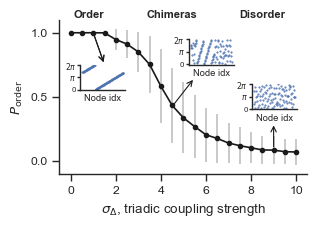

In [7]:
fig, ax = plt.subplots(figsize=(3.2, 2))

k2s = sorted(df["k2"].unique())
y_mean = np.mean(mean_order, axis=1)
y_std = np.std(mean_order, axis=1)

ax.errorbar(
    k2s,
    y_mean,
    yerr=y_std,
    marker="o",
    ms=3,
    color="k",
    ecolor="silver",
    mfc="k",
    zorder=0,
)

sb.despine()

ax.set_ylim([-0.1, 1.1])
ax.set_yticks([0, 0.5, 1])

ax.set_xlabel("$\sigma_{\Delta}$, triadic coupling strength")
ax.set_ylabel("$P_{\mathrm{order}}$")

# title = f"ring {suf}, N={N}, nreps={nreps}"
# ax.set_title(title)


# insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins1 = inset_axes(
    ax,
    width="100%",
    height="100%",
    bbox_to_anchor=(0.7, 0.6, 2, 0.2),
    bbox_transform=ax.transData,
)

plot_phases_line(data[2, 3, :, None], it=-1, ax=axins1, c="b", ms=0.5)

axins1.set_ylabel("")
plt.yticks(fontsize="xx-small")
axins1.set_xticks([])
# plt.yticks(fontsize="x-small")
axins1.set_xlabel("Node idx", fontsize="x-small", labelpad=3)

axins2 = inset_axes(
    ax,
    width="100%",
    height="100%",
    bbox_to_anchor=(5.5, 0.8, 2, 0.2),
    bbox_transform=ax.transData,
)

plot_phases_line(data[9, 2, :, None], it=-1, ax=axins2, c="b", ms=0.5)

axins2.set_ylabel("")
plt.yticks(fontsize="xx-small")
axins2.set_xticks([])
# plt.yticks(fontsize="x-small")
axins2.set_xlabel("Node idx", fontsize="x-small", labelpad=3)

axins3 = inset_axes(
    ax,
    width="100%",
    height="100%",
    bbox_to_anchor=(8.3, 0.45, 2, 0.2),
    bbox_transform=ax.transData,
)

plot_phases_line(data[-3, 7, :, None], it=-1, ax=axins3, c="b", ms=0.5)

axins3.set_ylabel("")
plt.yticks(fontsize="xx-small")
axins3.set_xticks([])
# plt.yticks(fontsize="x-small")
axins3.set_xlabel("Node idx", fontsize="x-small", labelpad=3)


axins1.tick_params("both", length=2, which="major", pad=1)
axins2.tick_params("both", length=2, which="major", pad=1)
axins3.tick_params("both", length=2, which="major", pad=1)

ax.text(0.8, 1.1, "Order", ha="center", va="bottom", weight="bold", fontsize="small")
ax.text(4.5, 1.1, "Chimeras", ha="center", va="bottom", weight="bold", fontsize="small")
ax.text(8.5, 1.1, "Disorder", ha="center", va="bottom", weight="bold", fontsize="small")

start_point = [1, 1]
end_point = [1.5, 0.75]
ax.annotate(
    "", xy=end_point, xytext=start_point, arrowprops={"arrowstyle": "->", "color": "k"}
)
start_point = [1, 1]
end_point = [1.5, 0.75]
ax.annotate(
    "", xy=end_point, xytext=start_point, arrowprops={"arrowstyle": "->", "color": "k"}
)
start_point = [4.52, 0.43]
end_point = [5.5, 0.65]
ax.annotate(
    "", xy=end_point, xytext=start_point, arrowprops={"arrowstyle": "->", "color": "k"}
)
start_point = [9, 0.09]
end_point = [9, 0.3]
ax.annotate(
    "",
    xy=end_point,
    xytext=start_point,
    zorder=5,
    arrowprops={"arrowstyle": "->", "color": "k"},
)

plt.savefig(f"{results_dir}figure_4.pdf", dpi=250, bbox_inches="tight", pad_inches=0)


# fig_name = f"local_order_ring_{suf}_N_{N}_nreps_{nreps}"
# plt.savefig(f"{run_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{results_dir}figure_4.png", dpi=250, bbox_inches="tight")

plt.show()